In [126]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress
import scipy.integrate as integrate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
from typing import Optional
import warnings

warnings.filterwarnings("ignore")

REFERENCE_POINT = {'N': 7536302.173999999649823, 'E': 651364.265000000013970}

def get_data(file: str, 
             remove_rows: list) -> pd.DataFrame:
    theodelite = pd.read_excel(file)
    for row in remove_rows:
        theodelite.drop(row, inplace=True)
    return theodelite

def make_float(x: str) -> float:
    x = str(x)
    x = x.replace(',', '.')
    return float(x)

def get_data_from_DGPS(file: str, 
                       x_cord: str, 
                       y_cord: str, 
                       z_cord: str, 
                       year: int, 
                       sep: str=';',
                       remove_rows: Optional[list] = None) -> pd.DataFrame:
    
    theodelite_raw = pd.read_csv(file, sep=sep)
    theodelite = pd.DataFrame()
    theodelite['vd'] = theodelite_raw[z_cord].apply(make_float)
    theodelite['year'] = year
    north = (theodelite_raw[x_cord].apply(make_float) - REFERENCE_POINT['N']) * 111.139
    east = (theodelite_raw[y_cord].apply(make_float) - REFERENCE_POINT['E']) * 111.139
    dist = np.sqrt(north**2+east**2) / 10**2
    #theodelite['hd'] = east
    theodelite['hd'] = dist
    if remove_rows:
        for row in remove_rows:
            theodelite.drop(row, inplace=True) 
    return theodelite

def scatter_plot(theodelite: pd.DataFrame, 
                 title: str) -> None:
    plt.scatter(theodelite.hd, theodelite.vd)
    plt.xlabel('Horizontal distance (m)')
    plt.ylabel('Vertical distance (m)')
    plt.title(title)
    plt.show()

def interpolation(theodelite: pd.DataFrame, 
                  title: str='None', 
                  plot: bool=False) -> interp1d:
    #f = interp1d(theodelite.hd, theodelite.vd)
    #f = UnivariateSpline(theodelite.hd, theodelite.vd)
    f = get_natural_cubic_spline_model(theodelite.hd, 
                                       theodelite.vd, 
                                       minval=min(theodelite.hd), 
                                       maxval=max(theodelite.hd), 
                                       n_knots=5)
    if plot:
        plt.plot(theodelite.hd, f.predict(theodelite.hd))
        plt.xlabel('Horizontal distance (m)')
        plt.ylabel('Vertical distance (m)')
        plt.title(title)
        plt.show()
    return lambda x: f.predict(x)
    
def linreg_plot_and_corr(theodelite: pd.DataFrame, 
                         title: str) -> tuple[int]:
    t1000less = theodelite[theodelite.hd < 1000]
    t1000high = theodelite[theodelite.hd > 1000]

    f1 = linregress(t1000less.hd, t1000less.vd)
    f2 = linregress(t1000high.hd, t1000high.vd)
    f_all = linregress(theodelite.hd, theodelite.vd)
    plt.plot(t1000less.hd, f1.intercept + f1.slope*t1000less.hd, 
             t1000high.hd, f1.intercept + f1.slope*t1000high.hd, '--', 
             color = 'olive', label = 'Below riegel')
    plt.plot(t1000high.hd, f2.intercept + f2.slope*t1000high.hd, 
             t1000less.hd, f2.intercept + f2.slope*t1000less.hd, '--', 
             color = 'lightblue', label = 'Above riegel')
    plt.xlabel('Horizontal distance (m)')
    plt.ylabel('Vertical distance (m)')
    plt.title('Center line profile Storglaciären (linear regression)')
    plt.legend()
    plt.show()
    corr_front = f1.rvalue**2
    corr_back = f2.rvalue**2
    corr_all = f_all.rvalue**2
    print(f'Correlation below riegel: {corr_front:.4f}. Correlation above riegel: {corr_back:.4f}.')
    print(f'Correlation all profile: {corr_all:.4f}.')
    return corr_front, corr_back, corr_all

def call_all(data: pd.DataFrame, year: int) -> None:
    scatter_plot(data, title=f'Scatter Storglaciären elevation, {year}')
    interpolation(data, title=f'Interpolation Storglaciären elevation, {year}', plot=True)
    
def combine_theodolite_measurments_plot(base_x: pd.Series, 
                                        *args: list[pd.DataFrame]) -> None:
    # Scatter plot
    for theo in args:
        plt.scatter(theo.hd, theo.vd, label=list(theo.year)[0])
    plt.ylabel('m a.s.l.')
    plt.xlabel('Horizontal distance (2019 reference stone, m)')
    plt.title('Storglaciären central line profile')
    plt.legend()
    plt.show()
    
    # Interpolation plot
    for theo in args:
        f = interpolation(theo)
        plt.plot(base_x, f(base_x), label=list(theo.year)[0])
    plt.ylabel('m a.s.l.')
    plt.xlabel('Horizontal distance (2019 reference stone, m)')
    plt.title('Storglaciären central line profile (interpolation)')
    plt.legend()
    plt.show()
    
def get_avg_diff_plot(theo1: pd.DataFrame, theo2: pd.DataFrame, title: str) -> None:
    x = np.linspace(200, 1100, 10**5)
    f = interpolation(theo1)
    g = interpolation(theo2)
    y = f(x)-g(x)
    f_lin = linregress(x, y)
    plt.plot(x, f(x)-g(x), '--', color = 'darkolivegreen', label = 'Observed interpol. diff.')
    plt.plot(x, f_lin.intercept + f_lin.slope*x, 'darkolivegreen', label = 'Linear regression')
    
    plt.scatter(650, f_lin.intercept + f_lin.slope*650, color = 'slategray', label = 'Average difference')
    plt.xlabel('Horizontal distance (2019 reference stone, m)')
    plt.ylabel('Elevation difference (m)')
    plt.title(title)
    plt.legend()
    plt.show()

    avg = integrate.quad(lambda x: f_lin.intercept + f_lin.slope*x, 200, 1100)[0]
    print('Average height difference:', round(avg / 900,2), 'm.')

In [127]:
def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

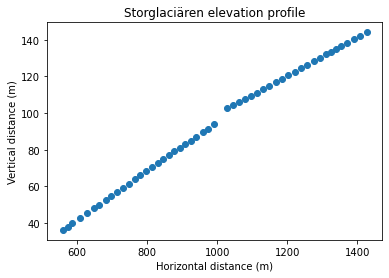

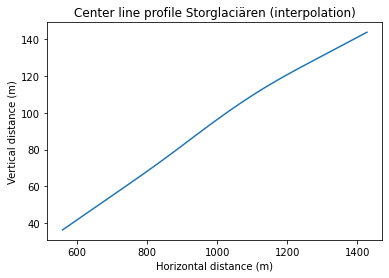

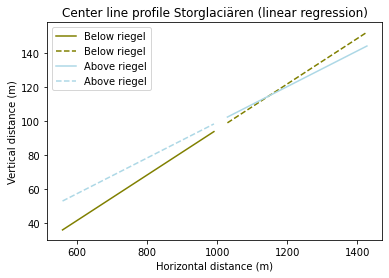

Correlation below riegel: 0.9999. Correlation above riegel: 0.9999.
Correlation all profile: 0.9964.


In [128]:
# Theodolite 2022 data with results
theodelite22 = get_data('theodelite.xlsx', [0,9, 29, 31])
scatter_plot(theodelite22, 'Storglaciären elevation profile')
interpolation(theodelite22, 'Center line profile Storglaciären (interpolation)', plot = True)
corrs = linreg_plot_and_corr(theodelite22, 'Linear correlation 2022')

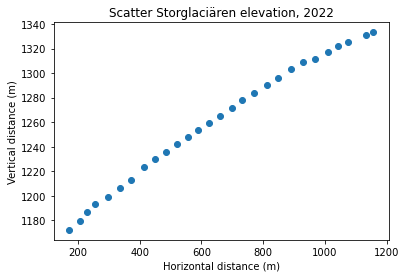

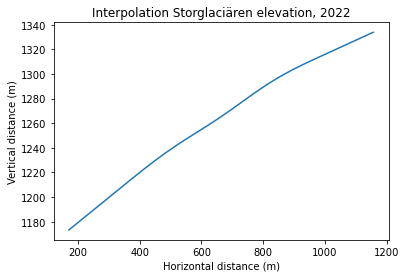

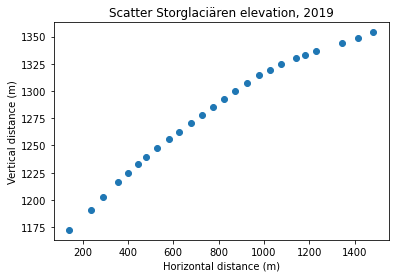

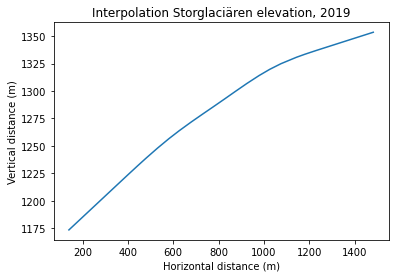

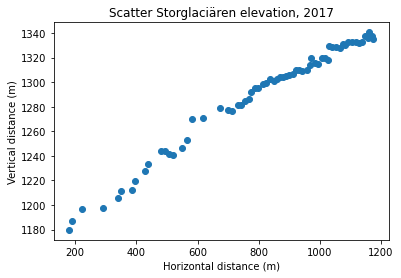

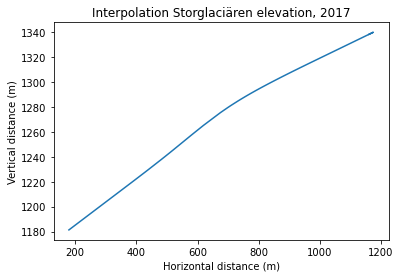

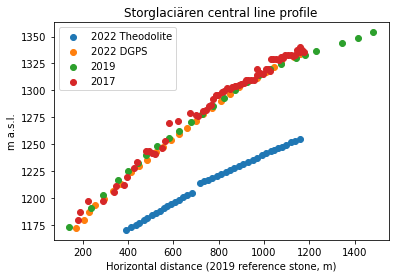

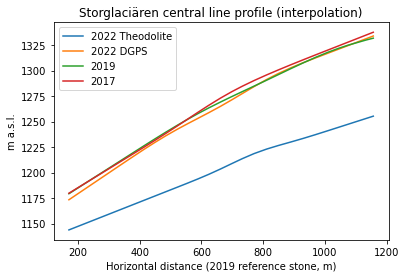

In [129]:
theodelite22 = get_data_from_DGPS('theodelite_2022.csv', 'Y','X', 'vd', year='2022 Theodolite', sep=',', remove_rows=[0])
theodelite22.vd = theodelite22.vd + 1118.05 - 7
theodelite22.hd = theodelite22.hd 
DGPS_data22 = get_data_from_DGPS('Point_generic_tarfalakurs.csv', 
                            'Northing', 
                            'Easting', 'MSL', year='2022 DGPS',sep = ',', remove_rows=[0,2, 30])
# Stone elevation P40 = 1115.9 + 2.15
call_all(DGPS_data22, 2022)

theodelite19 = get_data_from_DGPS('2019_DGPS_profile.txt', 'Northing', 'Easting', 'MSL', year='2019', remove_rows = [0])
call_all(theodelite19, 2019)

theodelite17 = get_data_from_DGPS('2017_DGPS_profile.txt', 'Y', 'X', 'Elevation', year='2017', remove_rows = [0,1])
call_all(theodelite17, 2017)

combine_theodolite_measurments_plot(DGPS_data22.hd, theodelite22, DGPS_data22, theodelite19, theodelite17)

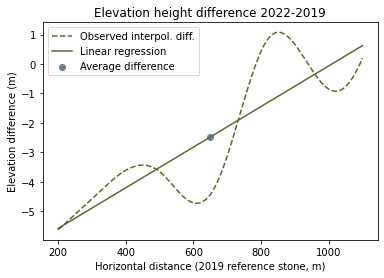

Average height difference: -2.48 m.


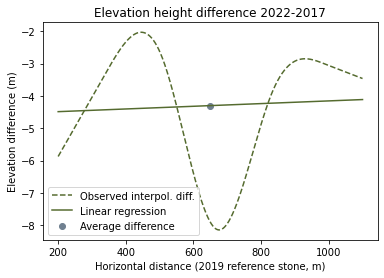

Average height difference: -4.3 m.


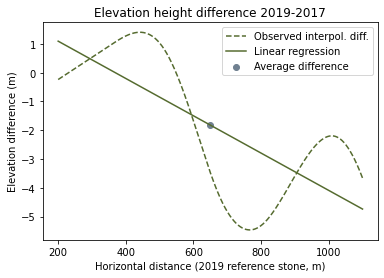

Average height difference: -1.82 m.


In [130]:

get_avg_diff_plot(DGPS_data22, theodelite19,'Elevation height difference 2022-2019')
get_avg_diff_plot(DGPS_data22, theodelite17,'Elevation height difference 2022-2017')
get_avg_diff_plot(theodelite19, theodelite17,'Elevation height difference 2019-2017')

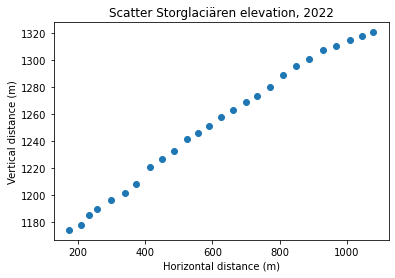

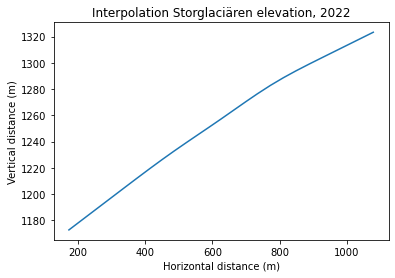

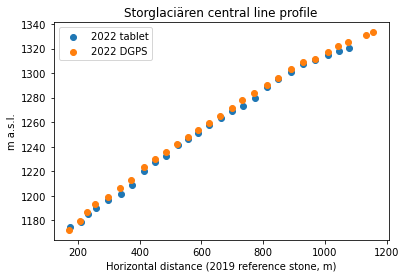

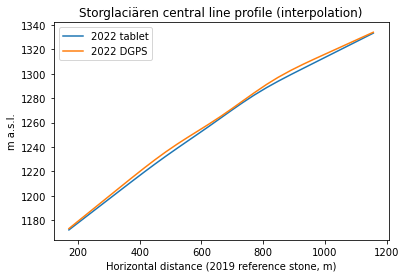

In [131]:
tablet_data22 = get_data_from_DGPS('2022_profile_tablet.csv', 
                                   'ycoord', 
                                   'xcoord', 
                                   'zcoord', 
                                   sep=',', 
                                   year='2022 tablet', remove_rows = [26])

call_all(tablet_data22, year=2022)
combine_theodolite_measurments_plot(DGPS_data22.hd, tablet_data22, DGPS_data22)

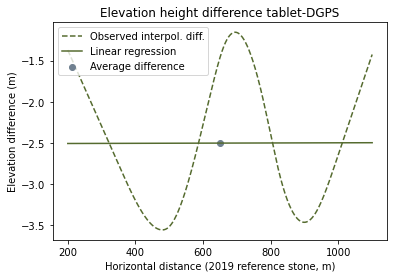

Average height difference: -2.5 m.


In [133]:
get_avg_diff_plot(tablet_data22, DGPS_data22, title='Elevation height difference tablet-DGPS')